# Generate Continuity Graphs

Another task you can accomplish with patent_client is automatic generation of continuity graphs, like this one:

![continuity_graph](./img/tesla_continuity.svg)

To do this, we're going to use patent_client in conjunction with [pandas](https://pandas.pydata.org/) and [pygraphviz](https://graphviz.readthedocs.io/en/stable/index.html). PyGraphviz is a set of python bindings to the [GraphViz](https://www.graphviz.org/) data graph visualization library. We can use it to generate figures that illustrate the relationships between patent applications. 

Let's begin with the standard imports, and indicate one of the applications in the family of interest. Here, we've picked a patent application owned by Tesla as an example:

In [1]:
import pandas as pd
from patent_client_plus import USApplication, Assignment

company_name = "CoVar"

def company_apps(company_name):
    applicant_apps = USApplication.objects.filter(first_named_applicant=company_name).values_list('appl_id', flat=True)
    # The assigned apps is either a single value, or a list of values if more than one property was assigned
    assigned_apps = list()
    for a in Assignment.objects.filter(assignee=company_name):
        for p in a.properties:
            assigned_apps.append(p.appl_id)
    all_apps = list(applicant_apps) + assigned_apps
    all_apps = list(set(all_apps)) # use set to deduplicate the list
    
    assignments_out = Assignment.objects.filter(assignor=company_name)
    assigned_out_apps = list()
    for assignment in assignments_out:
        if 'assignors interest' in assignment.conveyance_text.lower():
            a = assignment.appl_num
            if isinstance(a, list):
                assigned_out_apps += a
            else:
                assigned_out_apps.append(a)

    owned_apps = list(set(all_apps) - set(assigned_out_apps))
    return owned_apps

## Collect the Data

To collect all the data we need for our graph, we're going to need to iterate through the application, and every application related to it. We do that through an iterative algorithm that keeps a list of:

 - Applications it needs to retreive
 - Applications it has already retreived
 - Parent / Child data
 - A list of missing cases
 
Starting with the target patent, the algorithm retreives a case, records all the relationship data to the relevant lists, and adds a reference to the application itself to the applications list. With the data recorded, it then determines if any of the cases related to the current one haven't been visted yet. If they have not been visited, it adds them to the "to_visit" list. This process continues until the "to_visit" list is empty. The result is:

 - applications -> USApplication objects for the target and every related case
 - parent_entries -> Relationship objects for all parents of all applications
 - child_entries -> Relationship objects for all children of all applications
 - orphans -> application numbers for applications that were not found (typically an unpublished continuation application)
 

In [1]:
from patent_client import USApplication

visited = set()

#to_visit = "10932516, 12712544, 12565177, 13731446, 10195097, 10932516, 10731855, 14701894, 14701894, 14701829, 14800312, 14800264, 15465848".split(', ')
#to_visit = company_apps(company_name)
to_visit = set([USApplication.objects.get(patent_number="9116908")])
relationships = list()
orphans = list()

while to_visit:
    app = to_visit.pop()
    relationships += app.parents
    related_apps = set()
    for parent in app.parents:
        try:
            p_app = parent.parent
            related_apps.add(p_app)
        except Exception:
            orphans.append(parent.parent_appl_id)
            
    for child in app.children:
        try:
            c_app = child.child
            related_apps.add(c_app)
        except Exception:
            orphans.append(child.child_appl_id)
    visited.add(app)
    to_visit = (to_visit | related_apps) - visited

In [1]:
from patent_client_plus import USApplication

a = USApplication.objects.get(patent_number="9116908").family().generate_graph_diagram()

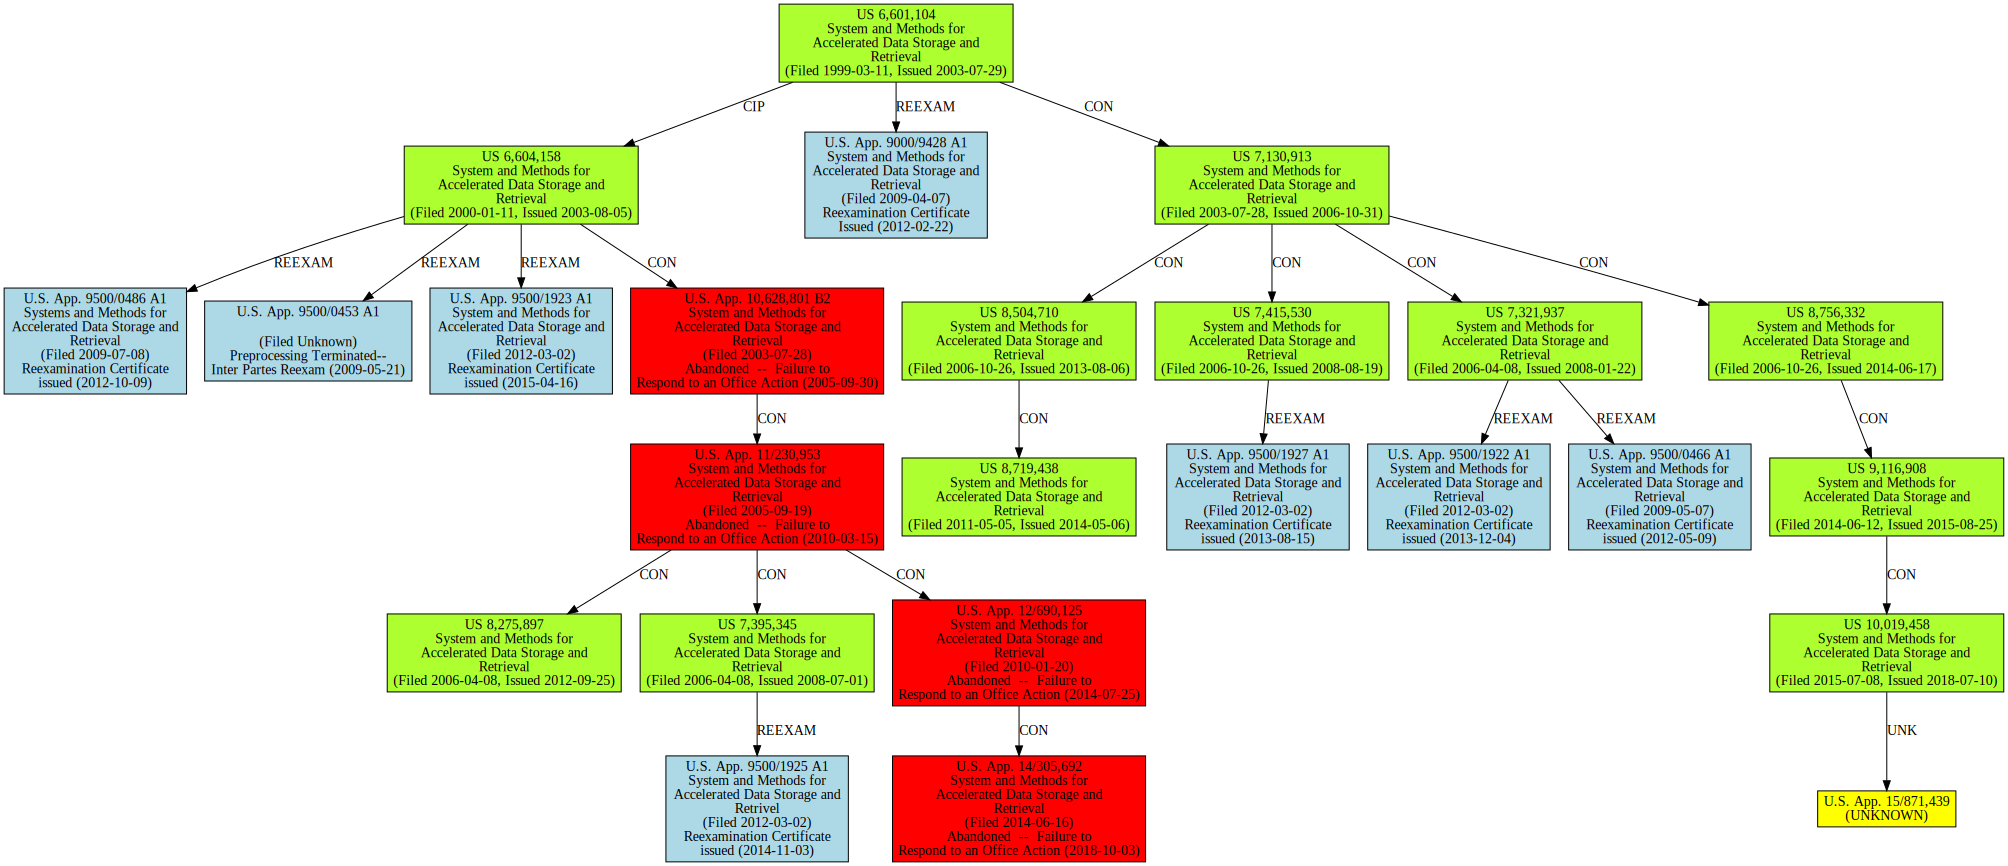

In [2]:
a

In [37]:
b.edges(data=True)[('12690125', '14305692')]

TypeError: 'OutEdgeDataView' object is not subscriptable

In [4]:

a

AttributeError: 'USApplicationFamily' object has no attribute 'primary_key'

In [24]:
b.edges['12690125', '14305692']

{'label': 'CON'}

In [17]:
import networkx as nx

list(nx.algorithms.dag.transitive_reduction(b).edges.data())

[('12690125', '14305692', {}),
 ('09266394', '90009428', {}),
 ('09266394', '10628795', {}),
 ('09266394', '09481243', {}),
 ('11553427', '13101994', {}),
 ('14794201', '15871439', {}),
 ('11400674', '95001922', {}),
 ('11400674', '95000466', {}),
 ('11553419', '14303276', {}),
 ('10628801', '11230953', {}),
 ('11230953', '12690125', {}),
 ('11230953', '11400008', {}),
 ('11230953', '11400322', {}),
 ('10628795', '11400674', {}),
 ('10628795', '11553427', {}),
 ('10628795', '11553419', {}),
 ('10628795', '11553426', {}),
 ('14303276', '14794201', {}),
 ('11553426', '95001927', {}),
 ('09481243', '95000453', {}),
 ('09481243', '95001923', {}),
 ('09481243', '10628801', {}),
 ('09481243', '95000486', {}),
 ('11400322', '95001925', {})]

For every application, the parent records indicate a clear relationship - e.g. continuation / divisional / etc, so we're only going to work with the parent entry data, which we can convert to a Pandas dataframe as:

In [3]:
cont_df = pd.DataFrame.from_records(r.as_dict() for r in parent_entries)
cont_df.head()

,appl_id,filing_date,patent_number,related_to_appl_id,relationship,status
0,61826690,2013-05-23,None,14284013,Claims Priority from Provisional Application,Expired
1,62078569,2014-11-12,None,14938467,Claims Priority from Provisional Application,Expired
2,62078587,2014-11-12,None,14938523,Claims Priority from Provisional Application,Expired
3,62078573,2014-11-12,None,14938962,Claims Priority from Provisional Application,Expired
4,62212252,2015-08-31,None,14938962,Claims Priority from Provisional Application,Expired


## Filter the Relationships

Now we have a problem. If we just graph this data, we get a total jumble. A lot of this parent data is duplicated. For example, assume we have 3 applications in the following relationship:

`Application A - is a CON of - Application B - is a CON of - Application C`

From the data we've pulled, we'll see three separate records:

| child | relationship | parent |
|-------|--------------|--------|
| A     | is a CON of  | B      |
| B     | is a CON of  | C      |
| A     | is a CON of  | C      |

But we only want two records. We don't care if A is a CON of C, because when we produce the graph, that will be shown by the fact that A is a CON of B, which is a CON of C. So we need to simplify the records. We use another algorithm.

Here, we iterate through each application, and pull all of its parents. We then iterate through each of its parents to determine grandparents. Any grandparents found are removed from the list of parents, and the surviving entries are added to a "filtered_cont_df" dataframe.

In [4]:
filtered_cont_df = pd.DataFrame()

for app in applications:
    parents = cont_df[cont_df['related_to_appl_id'] == app.appl_id]
    parent_ids = set(parents['appl_id'])
    for p in list(parent_ids):
        grand_parents = list(cont_df[cont_df['related_to_appl_id'] == p]['appl_id'])
        parent_ids = parent_ids - set(grand_parents)
    filtered_cont_df = pd.concat([filtered_cont_df, parents[parents['appl_id'].isin(parent_ids)]])

print(f'Compressed {len(cont_df)} relationships into {len(filtered_cont_df)} relationships')    
    

Compressed 23 relationships into 23 relationships


## Make the Relationships Look Nice

Now we're going to modify the filtered_cont_df DataFrame to make it look nicer. We will simplify each of the relationship types into neat 2-3 letter codes.

In [5]:
def assign_identifiers(string):
    string = string.lower()
    if ('continuation-in-part' in string 
        or 'continuation in part' in string):
        return 'CIP'
    elif 'continuation' in string:
        return 'CON'
    elif 'division' in string:
        return 'DIV'
    elif 'provisional' in string:
        return 'PRV'
    elif 'stage' in string:
        return 'NS'

filtered_cont_df['relationship'] = filtered_cont_df['relationship'].apply(assign_identifiers)
filtered_cont_df.head()


,appl_id,filing_date,patent_number,related_to_appl_id,relationship,status
0,61826690,2013-05-23,None,14284013,PRV,Expired
1,62078569,2014-11-12,None,14938467,PRV,Expired
2,62078587,2014-11-12,None,14938523,PRV,Expired
3,62078573,2014-11-12,None,14938962,PRV,Expired
4,62212252,2015-08-31,None,14938962,PRV,Expired


## Separate Families

Now we need to separate out the families. The previous analysis has essentially given us some graph data, with applications as nodes, and relationships as edges. To separate them out into groups, we will use the NetworkX graph library to split the families into unique groups.

In [6]:
import networkx as nx

# Generate a graph and create a list of independent groups
graph = nx.from_pandas_edgelist(filtered_cont_df, source="appl_id", target="related_to_appl_id", edge_attr="relationship")
family_sets = {i:list(members) for (i, members) in enumerate(nx.connected_components(graph))}

# Invert the groups to create a lookup dictionary
family_index = dict()

for family_id, appl_ids in family_sets.items():
    for appl_id in appl_ids:
        family_index[appl_id] = family_id

# Build an application dataframe annotated with family id
applications_df = pd.DataFrame(dict(
    app_obj=applications, 
    appl_id=[a.appl_id for a in applications], 
    family_id=[family_index.get(a.appl_id, None) for a in applications]
))            

# Add family id to continuity data
filtered_cont_df.loc[:, 'family_id'] = filtered_cont_df['appl_id'].apply(lambda x: family_index[x])

## Generate the Graph(s)

Now for the heavy-lifting. This is going to proceed in two stages. 

1. We're going to add in `node` objects for each application, with text that's descriptive of the case
2. We're going to add `edge` objects for each relationship, with the relationship code

The result can then be displayed in the notebook by simply calling the Graph object (dot), or by calling dot.render() GraphViz will save a file to disk containing the image.

In [13]:
from graphviz import Digraph
import textwrap
from titlecase import titlecase
from collections import OrderedDict
import datetime
from patent_client.parser import parse


def generate_graph(applications, relationships):
    # Create the Graph Object
    dot = Digraph(format='png', node_attr={'shape': 'rectangle', 'style': 'filled'})
    styles = ""

    # Stage 1 - Add the Nodes
    for app in applications:
        title = '\n'.join(textwrap.wrap(titlecase(getattr(app, 'patent_title', 'Unknown')), 30))
        string = 'U.S. App. ' + parse(app.appl_id).display()[3:] + f"\n{title}\n(Filed {getattr(app, 'app_filing_date', 'Unknown')})"
        color = 'orange'
        # Color PCT applications aquamarine
        if app.kind == "PCT":
            string = f"{parse(app.appl_id).display(style='new')}\n{title}\n(Filed {getattr(app, 'app_filing_date', 'Unknown')})\n"
            color = 'aquamarine'
            

        # Add patent information for issued patents
        elif "Patented" in app.app_status:
            string = f'{parse(app.patent_number).display()[:-2]}\n{title}\n(Filed {app.app_filing_date}, Issued {app.patent_issue_date})'
            color = 'greenyellow'
        
        elif "expired" in app.app_status.lower() and hasattr(app, "patent_number"):
            print(app.app_status)
            string = f'{parse(app.patent_number).display()[:-2]}\n{title}\n(Filed {app.app_filing_date}, Issued {app.patent_issue_date})'
            string = f'\nExpired {app.app_status_date}'
            color = 'orangered'

        elif app.kind == "Nonprovisional":
            status_text = app.app_status.split(' - ')[0].replace('Mailed', '').replace('Filed', '').replace(',', '\n').strip()
            status_text_wrapped = "\n".join(textwrap.wrap(status_text, 30))
            status = f'{status_text_wrapped} ({app.app_status_date})'
            string = string + f'\n{status}'
            if 'abandon' in app.app_status.lower():
                color = 'red'
            else:
                color = 'lightblue'
        
        dot.node(app.appl_id, string, fillcolor=color)
        string = string.replace('\n', '<br/>')
        styles += f"\tstyle {app.appl_id} fill:{color}\n"

    # Stage 2 - add the Edges
    for i, connection in relationships.iterrows():
            dot.edge(connection['appl_id'], connection['related_to_appl_id'], #connection['relationship'], 
                     splines='ortho')
    

    # Stage 3 - Annotate PCT Applications
    
    pct_apps = list(filter(lambda x: "PCT" in x.appl_id, applications))
    for pct in pct_apps:
        norm_pct = parse(pct.appl_id).display(style='new')
        family = filter(lambda x: x.country not in ["US", "WO"], pct.inpadoc.first().document.family)
        ns_apps = filter(lambda x: norm_pct in x.priority_claims, family)
        ns_nums = list(set(getattr(p, "application", p.publication) for p in ns_apps))
        if ns_nums:
            string = "National Stage Filings:\n"
            string += "\n".join(ns_nums)
        else:
            string = "No National Stage\nApplications Filed"
        #string = string.replace('\n', '<br/>')
        node_id = norm_pct + 'NS'
        dot.node(node_id, string, fillcolor="aquamarine")
        styles += f"\tstyle {node_id} fill:aquamarine\n"
        dot.edge(pct.appl_id, node_id, #"NS", 
                 splines='ortho')
    return dot
        

graphs = list()

for family_id in list(set(applications_df['family_id'])):
    applications = applications_df[applications_df['family_id'] == family_id]['app_obj']
    relationships = filtered_cont_df[filtered_cont_df['family_id'] == family_id]
    graphs.append(generate_graph(applications, relationships))

/Users/parkerhancock/.patent_client/epo/published-data_searchb04bf1957a91e6610ab1538c056d0f53.xml
/Users/parkerhancock/.patent_client/epo/published-data_searchb04bf1957a91e6610ab1538c056d0f53.xml
/Users/parkerhancock/.patent_client/epo/published-data_publication_docdb_CA.2913294.A1_biblio.xml
/Users/parkerhancock/.patent_client/epo/family_publication_docdb_CA.2913294.A1_.xml
/Users/parkerhancock/.patent_client/epo/published-data_publication_docdb_CA.2913294.A1_biblio.xml
/Users/parkerhancock/.patent_client/epo/published-data_publication_docdb_EP.2999846.A2_biblio.xml
/Users/parkerhancock/.patent_client/epo/published-data_publication_docdb_EP.2999846.B1_biblio.xml
/Users/parkerhancock/.patent_client/epo/published-data_publication_docdb_US.2014345940.A1_biblio.xml
/Users/parkerhancock/.patent_client/epo/published-data_publication_docdb_US.9708898.B2_biblio.xml
/Users/parkerhancock/.patent_client/epo/published-data_publication_docdb_WO.2014189992.A2_biblio.xml
/Users/parkerhancock/.patent

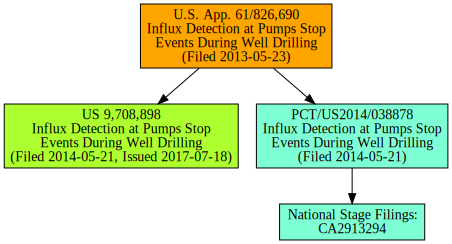

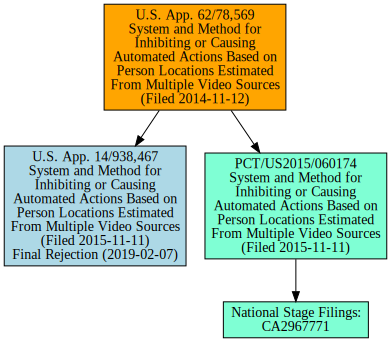

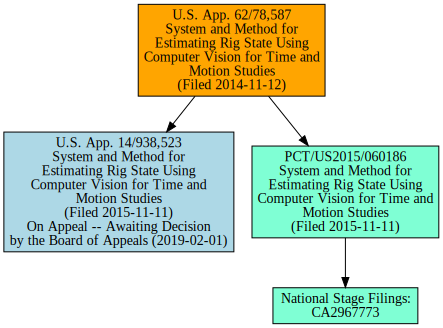

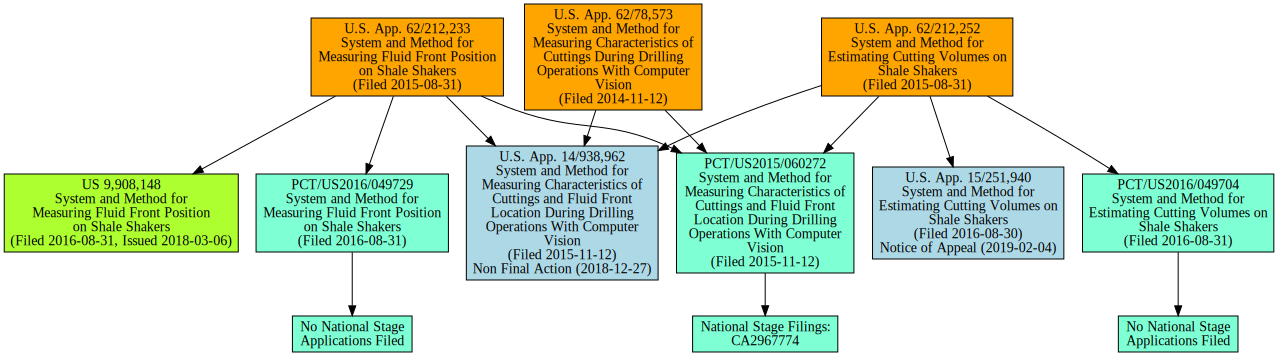

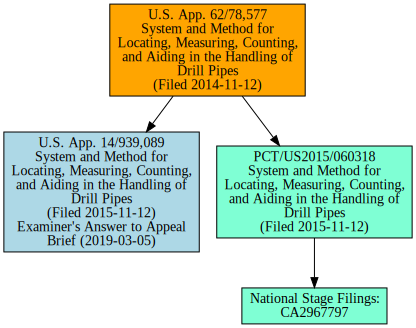

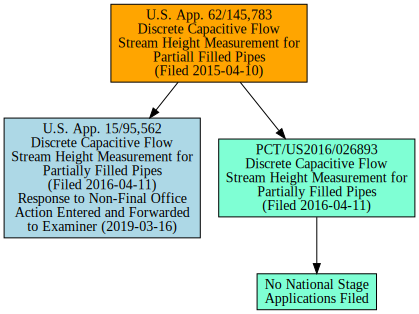

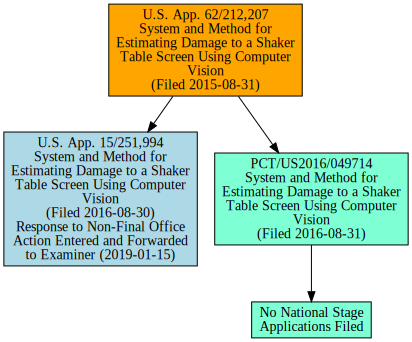

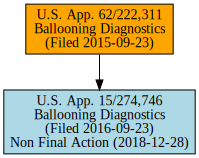

In [14]:
from IPython.display import display

for graph in graphs:
    display(graph)

In [15]:
for i in range(len(graphs)):
    try:
        earliest_app = sorted(applications_df[applications_df['family_id'] == i]['app_obj'], key=lambda x: x.app_filing_date)[0]
    except IndexError:
        continue
    family_name = f"{titlecase(company_name)} - {titlecase(earliest_app.patent_title)}"
    graphs[i].render(filename=family_name, cleanup=True)

In [10]:
from patent_client import Inpadoc

results = Inpadoc.objects.filter(applicant="Motive Drilling")


<InpadocResult(AU2019200737A1)>

In [11]:
results[0].data

{'country': 'AU',
 'number': '2019200737',
 'kind': 'A1',
 'date': None,
 'doc_type': 'publication',
 'family_id': None,
 'doc_db': DocDB(country='AU', number='2019200737', kind='A1', date=None, doc_type='publication', family_id=None)}

In [12]:
family_sets

{0: ['61826690', '14284013', 'PCT/US14/38878'],
 1: ['14938467', 'PCT/US15/60174', '62078569'],
 2: ['PCT/US15/60186', '14938523', '62078587'],
 3: ['PCT/US15/60272',
  '62212233',
  'PCT/US16/49729',
  '15252319',
  'PCT/US16/49704',
  '15251940',
  '62212252',
  '14938962',
  '62078573'],
 4: ['62078577', '14939089', 'PCT/US15/60318'],
 5: ['15095562', '62145783', 'PCT/US16/26893'],
 6: ['PCT/US16/49714', '62212207', '15251994'],
 7: ['62222311', '15274746']}